# Graduation Rate Prediction
## Derek Caramella
## 2 May 2022

# Table of Contents
1. [Modules](#modules)
    1. [Import Modules](#import-modules)
2. [ETL](#etl)
    1. [Preprocessing Graduation Rate DataFrame](#preprocess-graduation-rate)
    2. [Preprocessing Accountability Status DataFrame](#preprocess-accountability-status)
    3. [Preprocessing Expenditures DataFrame](#preprocess-expenditures)
    4. [Preprocessing Inexperienced DataFrame](#preprocess-inexperienced)
    5. [Preprocessing Institution Grouping DataFrame](#preprocess-institution)
    6. [Preprocessing Teach Out of of Certification DataFrame](#preprocess-tech-out)
    7. [Merge](#merge)
2. [Descriptive Analysis](#descriptive-analysis)
    1. [Descriptive Statistics](#descriptive-statistics)
    2. [Graduation Rate Histogram](#grad-rate-hist)
    3. [Funding per Student Boxenplot](#fund-per-student-boxen)
    4. [Graduation Rate by Funding per Student](#grad-rate-fund-per-student)
    5. [PCA](#pca)
    6. [Teacher Representation](#teacher-representation)
    7. [Overall Status - Pie Chart](#overall-status-pie)
3. [Model Creation & Predicition](#model-creation-prediction)
    1. [Train-Test Split](#train-test-split)
    2. [Composite Model](#composite-model)
    2. [Model Creation](#model-creation)
    3. [Prediction](#prediction)
    4. [Evaulation](#evaulation)

# Modules
<a class='anchor' id='modules'></a>

## Import Modules
<a class='anchor' id='import-modules'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import colors

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, median_absolute_error


plt.rcParams['font.family'] = 'Times New Roman'  # Set plt shows font to Times New Roman

# ETL
<a class='anchor' id='etl'></a>

In [2]:
graduation_rate_df = pd.read_excel(io='Data/RawData.xlsx', sheet_name='ACC HS Graduation Rate')
account_status_df = pd.read_excel(io='Data/RawData.xlsx', sheet_name='Accountability Status')
expenditures_df = pd.read_excel(io='Data/RawData.xlsx', sheet_name='Expenditures per Pupil')
inexperienced_df = pd.read_excel(io='Data/RawData.xlsx', sheet_name='Inexperienced Teachers and Prin')
institution_grouping_df = pd.read_excel(io='Data/RawData.xlsx', sheet_name='Institution Grouping')
teach_out_of_cert_df = pd.read_excel(io='Data/RawData.xlsx', sheet_name='Teachers Teaching Out of Certif')

## Preprocessing Graduation Rate DataFrame
<a class='anchor' id='preprocess-graduation-rate'></a>

In [3]:
graduation_rate_df = graduation_rate_df[(graduation_rate_df['COHORT'] == 'Combined')
                                        & 
                                        (graduation_rate_df['SUBGROUP_NAME' ]== 'All Students') 
                                        & 
                                        (graduation_rate_df['GRAD_RATE'] != 's')]
graduation_rate_df['GRAD_RATE'] = graduation_rate_df['GRAD_RATE'].astype(float)
graduation_rate_df = graduation_rate_df[graduation_rate_df['GRAD_RATE'] > 10]

graduation_rate_df = graduation_rate_df[['INSTITUTION_ID', 'ENTITY_CD', 'ENTITY_NAME', 'YEAR', 'SUBGROUP_NAME',
                                         'COHORT', 'COHORT_COUNT',
                                         'GRAD_RATE']]
graduation_rate_df.head(3)

,INSTITUTION_ID,ENTITY_CD,ENTITY_NAME,YEAR,SUBGROUP_NAME,COHORT,COHORT_COUNT,GRAD_RATE
79768,800000055729,10100010000,ALBANY CITY SCHOOL DISTRICT,2019,All Students,Combined,s,68.9
79804,800000055743,10100010034,ALBANY HIGH SCHOOL,2019,All Students,Combined,s,70.3
79851,800000059776,10100860907,GREEN TECH HIGH CHARTER SCHOOL,2019,All Students,Combined,s,93.3


## Preprocessing Accountability Status DataFrame
<a class='anchor' id='preprocess-accountability-status'></a>

In [4]:
account_status_df = account_status_df[['INSTITUTION_ID', 'ENTITY_CD', 'ENTITY_NAME', 'YEAR', 'OVERALL_STATUS']]
account_status_df = account_status_df.dropna()
account_status_df.head(3)

,INSTITUTION_ID,ENTITY_CD,ENTITY_NAME,YEAR,OVERALL_STATUS
0,800000055729,10100010000,ALBANY CITY SCHOOL DISTRICT,2020,Target District
1,800000055730,10100010014,MONTESSORI MAGNET SCHOOL,2020,Good Standing
2,800000055731,10100010016,PINE HILLS ELEMENTARY SCHOOL,2020,Good Standing


## Preprocessing Expenditures DataFrame
<a class='anchor' id='preprocess-expenditures'></a>

In [5]:
expenditures_df = expenditures_df[['INSTITUTION_ID', 'ENTITY_CD', 'ENTITY_NAME', 'YEAR', 'PUPIL_COUNT_TOT',
                                   'PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP', 'PER_FED_STATE_LOCAL_EXP']]
expenditures_df.head(3)

,INSTITUTION_ID,ENTITY_CD,ENTITY_NAME,YEAR,PUPIL_COUNT_TOT,PER_FEDERAL_EXP,PER_STATE_LOCAL_EXP,PER_FED_STATE_LOCAL_EXP
0,800000055479,10201040001,BERNE-KNOX-WESTERLO JUNIOR-SENIOR HIGH SCHOOL,2019,347,437,18507,18944
1,800000055480,10201040002,BERNE-KNOX-WESTERLO ELEMENTARY SCHOOL,2019,408,510,10873,11383
2,800000055452,10306060000,BETHLEHEM CENTRAL SCHOOL DISTRICT,2019,4440,259,16405,16664


## Preprocessing Inexperienced DataFrame
<a class='anchor' id='preprocess-inexperienced'></a>

In [6]:
inexperienced_df = inexperienced_df[['INSTITUTION_ID', 'ENTITY_CD', 'ENTITY_NAME', 'YEAR', 
                                     'NUM_TEACH', 'NUM_TEACH_INEXP',
                                     'NUM_PRINC', 'NUM_PRINC_INEXP']]
inexperienced_df = inexperienced_df.dropna()
inexperienced_df.head(3)

,INSTITUTION_ID,ENTITY_CD,ENTITY_NAME,YEAR,NUM_TEACH,NUM_TEACH_INEXP,NUM_PRINC,NUM_PRINC_INEXP
0,800000055729,10100010000,ALBANY CITY SCHOOL DISTRICT,2019,723.0,76.0,18.0,3.0
1,800000055730,10100010014,MONTESSORI MAGNET SCHOOL,2019,27.0,1.0,1.0,0.0
2,800000055731,10100010016,PINE HILLS ELEMENTARY SCHOOL,2019,27.0,1.0,2.0,1.0


## Preprocessing Institution Grouping DataFrame
<a class='anchor' id='preprocess-institution'></a>

In [7]:
institution_grouping_df = institution_grouping_df[institution_grouping_df['GROUP_NAME'] == 'Public School']
institution_grouping_df = institution_grouping_df.dropna()
institution_grouping_df.head(3)

,INSTITUTION_ID,GROUP_CODE,GROUP_NAME,ENTITY_CD,ENTITY_NAME
520,800000055730,6,Public School,10100010014,MONTESSORI MAGNET SCHOOL
521,800000055731,6,Public School,10100010016,PINE HILLS ELEMENTARY SCHOOL
522,800000055732,6,Public School,10100010018,DELAWARE COMMUNITY SCHOOL


## Preprocessing Teach Out of of Certification DataFrame
<a class='anchor' id='preprocess-tech-out'></a>

In [8]:
teach_out_of_cert_df = teach_out_of_cert_df[['INSTITUTION_ID', 'ENTITY_CD', 'ENTITY_NAME', 'YEAR', 
                                             'NUM_TEACH_OC', 'NUM_OUT_CERT']]
teach_out_of_cert_df = teach_out_of_cert_df.dropna()
teach_out_of_cert_df.head(3)

,INSTITUTION_ID,ENTITY_CD,ENTITY_NAME,YEAR,NUM_TEACH_OC,NUM_OUT_CERT
0,800000055729,10100010000,ALBANY CITY SCHOOL DISTRICT,2019,760.0,36.0
1,800000055730,10100010014,MONTESSORI MAGNET SCHOOL,2019,22.0,0.0
2,800000055731,10100010016,PINE HILLS ELEMENTARY SCHOOL,2019,24.0,0.0


## Merge
<a class='anchor' id='merge'></a>

In [9]:
model_df = pd.merge(graduation_rate_df, account_status_df, right_on=['ENTITY_CD', 'YEAR'], 
                    left_on=['ENTITY_CD', 'YEAR'], how='inner')
model_df = pd.merge(model_df, expenditures_df, right_on=['ENTITY_CD', 'YEAR'], left_on=['ENTITY_CD', 'YEAR'],
                    how='inner')
model_df = pd.merge(model_df, inexperienced_df, right_on=['ENTITY_CD', 'YEAR'], left_on=['ENTITY_CD', 'YEAR'],
                    how='inner')
model_df = pd.merge(model_df, institution_grouping_df, right_on='ENTITY_CD', left_on='ENTITY_CD',
                    how='inner')
model_df = pd.merge(model_df, teach_out_of_cert_df, right_on=['ENTITY_CD', 'YEAR'], left_on=['ENTITY_CD', 'YEAR'],
                    how='inner')

model_df = model_df[['INSTITUTION_ID_x', 'ENTITY_CD', 'ENTITY_NAME_x', 'YEAR',
                     'COHORT_COUNT', 'GRAD_RATE', 'OVERALL_STATUS',
                     'PUPIL_COUNT_TOT', 'PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP', 'PER_FED_STATE_LOCAL_EXP',
                     'NUM_TEACH', 'NUM_TEACH_INEXP', 'NUM_PRINC', 'NUM_PRINC_INEXP',  
                     'GROUP_NAME',
                     'NUM_TEACH_OC', 'NUM_OUT_CERT']]
model_df = model_df.loc[:, ~model_df.columns.duplicated()]  # Drop duplicate columns from join
model_df = model_df.rename(columns={'INSTITUTION_ID_x': 'INSTITUTION_ID', 'ENTITY_NAME_x': 'ENTITY_NAME'})
model_df.head(6)

,INSTITUTION_ID,ENTITY_CD,ENTITY_NAME,YEAR,COHORT_COUNT,GRAD_RATE,OVERALL_STATUS,PUPIL_COUNT_TOT,PER_FEDERAL_EXP,PER_STATE_LOCAL_EXP,PER_FED_STATE_LOCAL_EXP,NUM_TEACH,NUM_TEACH_INEXP,NUM_PRINC,NUM_PRINC_INEXP,GROUP_NAME,NUM_TEACH_OC,NUM_OUT_CERT
0,800000055743,10100010034,ALBANY HIGH SCHOOL,2019,s,70.3,Good Standing,2548,309,12962,13272,210.0,30.0,1.0,1.0,Public School,171.0,14.0
1,800000059776,10100860907,GREEN TECH HIGH CHARTER SCHOOL,2019,s,93.3,Good Standing,338,453,14473,14926,36.0,4.0,1.0,1.0,Public School,27.0,13.0
2,800000068133,10100860960,ALBANY LEADERSHIP CHARTER HIGH SCHOOL FOR GIRLS,2019,s,82.4,Good Standing,353,814,14923,15737,40.0,14.0,2.0,2.0,Public School,33.0,20.0
3,800000055479,10201040001,BERNE-KNOX-WESTERLO JUNIOR-SENIOR HIGH SCHOOL,2019,s,94.5,Good Standing,347,437,18507,18944,45.0,7.0,1.0,0.0,Public School,43.0,1.0
4,800000055439,10306060008,BETHLEHEM CENTRAL SENIOR HIGH SCHOOL,2019,s,95.6,Good Standing,1559,120,11359,11479,120.0,14.0,1.0,1.0,Public School,107.0,0.0
5,800000055436,10402060001,RAVENA-COEYMANS-SELKIRK SENIOR HIGH SCHOOL,2019,s,88.2,Good Standing,557,357,13266,13623,58.0,6.0,1.0,0.0,Public School,56.0,1.0


In [10]:
model_df['COHORT_COUNT'] = np.where(model_df['COHORT_COUNT'] == 's', model_df['PUPIL_COUNT_TOT'], model_df['COHORT_COUNT'])
model_df['PUPIL_COUNT_TOT'] = np.where(model_df['PUPIL_COUNT_TOT'] == 's', model_df['COHORT_COUNT'], model_df['PUPIL_COUNT_TOT'])
model_df['COHORT_COUNT'] = model_df[['COHORT_COUNT', 'PUPIL_COUNT_TOT']].max(axis=1)
model_df = model_df.drop(['PUPIL_COUNT_TOT'], axis=1)
model_df = model_df[model_df['COHORT_COUNT'] != 's']
model_df = model_df.dropna(subset=['COHORT_COUNT'])


model_df['NUM_TEACH'] = np.where(model_df['NUM_TEACH'] == 's', model_df['NUM_TEACH_OC'], model_df['NUM_TEACH'])
model_df['NUM_TEACH_OC'] = np.where(model_df['NUM_TEACH_OC'] == 's', model_df['NUM_TEACH'], model_df['NUM_TEACH_OC'])
model_df['NUM_TEACH'] = model_df[['NUM_TEACH', 'NUM_TEACH_OC']].max(axis=1)
model_df = model_df.drop(['NUM_TEACH_OC'], axis=1)
model_df = model_df[model_df['NUM_TEACH'] != 's']
model_df = model_df.dropna(subset=['NUM_TEACH'])

# Descriptive Analysis
<a class='anchor' id='descriptive-analysis'></a>

## Descriptive Statistics
<a class='anchor' id='descriptive-statistics'></a>

In [11]:
model_df.loc[:, ~model_df.columns.isin(['INSTITUTION_ID', 'ENTITY_CD', 'YEAR', 'OVERALL_STATUS'])].describe()

,COHORT_COUNT,GRAD_RATE,PER_FEDERAL_EXP,PER_STATE_LOCAL_EXP,PER_FED_STATE_LOCAL_EXP,NUM_TEACH,NUM_TEACH_INEXP,NUM_PRINC,NUM_PRINC_INEXP,NUM_OUT_CERT
count,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000,1187.000000
mean,724.443134,85.857793,698.782645,15577.673968,16276.420388,61.746420,9.422915,1.074979,0.295703,6.897220
std,642.899353,14.871498,592.168741,4364.967214,4459.052714,43.386773,8.819613,0.432966,0.517166,10.389524
min,30.000000,12.800000,0.000000,0.000000,12.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,341.000000,81.650000,252.500000,12859.000000,13440.500000,33.000000,4.000000,1.000000,0.000000,1.000000
50%,495.000000,90.800000,581.000000,14978.000000,15759.000000,45.000000,7.000000,1.000000,0.000000,3.000000
75%,917.500000,95.500000,989.000000,17607.500000,18471.500000,79.000000,12.000000,1.000000,1.000000,9.000000
max,5942.000000,100.000000,5548.000000,44081.000000,44348.000000,319.000000,70.000000,5.000000,4.000000,80.000000


## Graduation Rate Histogram
<a class='anchor' id='grad-rate-hist'></a>

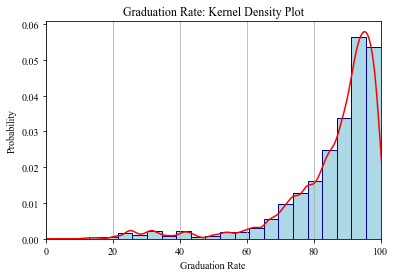

In [12]:
fig, ax = plt.subplots()

model_df['GRAD_RATE'].plot.kde(bw_method=0.1, 
                               ax=ax, legend=False, color='red',
                               title='Graduation Rate: Kernel Density Plot')
model_df['GRAD_RATE'].hist(edgecolor='#00008b', color='#ADD8E6', bins=20, density=True, ax=ax)
ax.set_ylabel('Probability')
ax.set_xlabel('Graduation Rate')
ax.set_xlim([0, 100])
ax.grid(axis='y')

plt.show()

## Funding per Student Boxenplot
<a class='anchor' id='fund-per-student-boxen'></a>

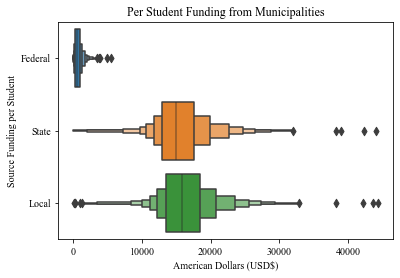

In [13]:
boxenplot_df = model_df.copy()[['PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP', 'PER_FED_STATE_LOCAL_EXP']]
boxenplot_df = pd.melt(boxenplot_df)

boxen_plot_labels_dict = {'PER_FEDERAL_EXP': 'Federal', 
                          'PER_STATE_LOCAL_EXP': 'State',
                          'PER_FED_STATE_LOCAL_EXP': 'Local'}
boxenplot_df['variable'] = boxenplot_df['variable'].map(boxen_plot_labels_dict)


fig, ax = plt.subplots()
sns.boxenplot(data=boxenplot_df, x='value', y='variable', ax=ax)
ax.set_ylabel('Source Funding per Student')
ax.set_xlabel('American Dollars (USD$)')
ax.set_title('Per Student Funding from Municipalities')
plt.show()

## Graduation Rate by Funding per Student
<a class='anchor' id='grad-rate-fund-per-student'></a>

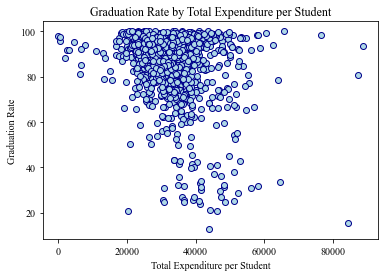

In [14]:
fig, ax = plt.subplots()
ax.scatter(x=model_df[['PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP', 'PER_FED_STATE_LOCAL_EXP']].sum(axis=1), 
           y=model_df['GRAD_RATE'], 
           edgecolor='#00008b', color='#ADD8E6')
ax.set_ylabel('Graduation Rate')
ax.set_xlabel('Total Expenditure per Student')
ax.set_title('Graduation Rate by Total Expenditure per Student')

plt.show()

## PCA
<a class='anchor' id='pca'></a>

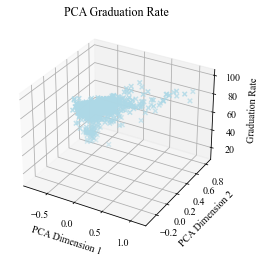

PCA Explained Variance: 0.529


In [15]:
fig_PCA = PCA(n_components=2)
pca_minmax_enc = MinMaxScaler()
pca_minmaxed_data = pca_minmax_enc.fit_transform(model_df[['COHORT_COUNT', 'GRAD_RATE', 'PER_FEDERAL_EXP', 
                                                           'PER_STATE_LOCAL_EXP', 'PER_FED_STATE_LOCAL_EXP',
                                                           'NUM_TEACH', 'NUM_TEACH_INEXP', 'NUM_PRINC',
                                                           'NUM_PRINC_INEXP', 'NUM_OUT_CERT']])
pca_processed_matrix = fig_PCA.fit_transform(pca_minmaxed_data)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca_processed_matrix[:, 0],
           pca_processed_matrix[:, 1],
           model_df['GRAD_RATE'],
           edgecolor='#00008b', color='#ADD8E6',
           marker='x')

ax.set_xlabel('PCA Dimension 1')
ax.set_ylabel('PCA Dimension 2')
ax.set_zlabel('Graduation Rate')
ax.set_title('PCA Graduation Rate')

plt.show()
print(f'PCA Explained Variance: {np.round(fig_PCA.explained_variance_ratio_.sum(), 3)}')

## Overall Status - Pie Chart 
<a class='anchor' id='overall-status-pie'></a>

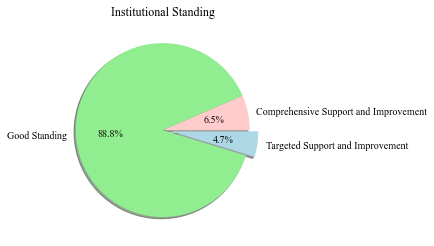

In [16]:
overall_status_df = model_df.copy()[['OVERALL_STATUS']]
overall_status_df['Representation'] = 1

overall_status_df = overall_status_df.groupby('OVERALL_STATUS', as_index=False).sum()
overall_status_df = overall_status_df.rename(columns={'OVERALL_STATUS': 'Institutional Standing'})


fig, ax = plt.subplots()
ax.pie(labels=overall_status_df['Institutional Standing'], 
       x=overall_status_df['Representation'],
       autopct='%1.1f%%', explode=[0, 0, 0.1], 
       colors=['#ffcccb', '#90EE90', '#ADD8E6'], shadow=True)

ax.set_title('Institutional Standing')

plt.show()

## Teacher Representation
<a class='anchor' id='teacher-representation'></a>

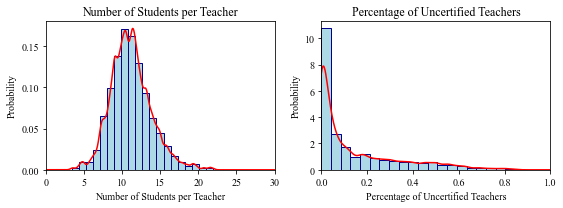

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

(model_df['COHORT_COUNT']/model_df['NUM_TEACH']).plot.kde(bw_method=0.1, 
                               ax=ax1, legend=False, color='red',
                               title='Number of Students per Teacher')
(model_df['COHORT_COUNT']/model_df['NUM_TEACH']).hist(edgecolor='#00008b', color='#ADD8E6', bins=20, 
                                                      density=True, ax=ax1)
ax1.set_ylabel('Probability')
ax1.set_xlabel('Number of Students per Teacher')
ax1.set_xlim([0, 30])
ax1.grid()

(model_df['NUM_OUT_CERT']/model_df['NUM_TEACH']).plot.kde(bw_method=0.1, 
                               ax=ax2, legend=False, color='red',
                               title='Percentage of Uncertified Teachers')
((model_df['NUM_OUT_CERT']/model_df['NUM_TEACH'])).hist(edgecolor='#00008b', color='#ADD8E6', bins=20, 
                                                      density=True, ax=ax2)
ax2.set_ylabel('Probability')
ax2.set_xlabel('Percentage of Uncertified Teachers')
ax2.set_xlim([0, 1])
ax2.grid()


plt.show()

# Model Creation & Predicition
<a class='anchor' id='model-creation-prediction'></a>

## Train-Test Split
<a class='anchor' id='train-test-split'></a>

In [18]:
X = model_df.loc[:, model_df.columns != 'GRAD_RATE']
y = model_df['GRAD_RATE']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=255)

## Composite Model
<a class='anchor' id='composite-model'></a>

In [20]:
class compositeModel:
    def __init__(self, sklearn_model):
        self.clf = sklearn_model
        self.scalers_trained = False
        self.model_trained = False
        
    def _train_scalers(self, x):
        self.clf_scaler = MinMaxScaler()
        self.clf_scaler.fit(x[['COHORT_COUNT', 'PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP', 'PER_FED_STATE_LOCAL_EXP',
                               'TeachersPerPupil', 'InexpTeachersPerPupil', 'InexpTeachersPerTeacher', 
                               'PrincipalsperPupil', 'InexpPrincipalsPerPupil', 'InexpPrincipalsPerPrincipal',
                               'OutofCertTeachersPerPupil', 'OutofCertTeachersPerTeacher']])
        self.overall_status_one_hot_enc = OneHotEncoder()
        self.overall_status_one_hot_enc.fit(x[['OVERALL_STATUS']].to_numpy())
        self.scalers_trained = True
    
    def _x_preprocessing(self, x, training=True):
        try:
            x[['OVERALL_STATUS', 'COHORT_COUNT',
               'PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP', 'PER_FED_STATE_LOCAL_EXP',
               'NUM_TEACH', 'NUM_TEACH_INEXP', 
               'NUM_PRINC', 'NUM_PRINC_INEXP',
               'GROUP_NAME', 'NUM_OUT_CERT']]
        except KeyError:
            print('Incorrect dependent variables.')
            return False
        
        # Feature Engineering
        x['TeachersPerPupil'] = x['NUM_TEACH']/x['COHORT_COUNT']
        x['InexpTeachersPerPupil'] = x['NUM_TEACH_INEXP']/x['COHORT_COUNT']
        x['InexpTeachersPerTeacher'] = x['NUM_TEACH_INEXP']/x['NUM_TEACH']
        
        x['PrincipalsperPupil'] = x['NUM_PRINC']/x['COHORT_COUNT']
        x['InexpPrincipalsPerPupil'] = x['NUM_TEACH_INEXP']/x['COHORT_COUNT']
        x['InexpPrincipalsPerPrincipal'] = x['NUM_PRINC_INEXP']/x['NUM_PRINC']
        x['OutofCertTeachersPerPupil'] = x['NUM_OUT_CERT']/x['COHORT_COUNT']
        x['OutofCertTeachersPerTeacher'] = x['NUM_OUT_CERT']/x['NUM_TEACH']
        
        x = x.replace(np.inf, 1)
        x = x.replace(np.NINF, 0)
        
        x = x.fillna(0)  # THIS NEEDS TO FIXED!!!!!
        
        features_minmax_scaled = ['COHORT_COUNT', 'PER_FEDERAL_EXP', 'PER_STATE_LOCAL_EXP',
                                  'PER_FED_STATE_LOCAL_EXP', 'TeachersPerPupil', 'InexpTeachersPerPupil', 
                                  'InexpTeachersPerTeacher', 'PrincipalsperPupil', 'InexpPrincipalsPerPupil',
                                  'InexpPrincipalsPerPrincipal', 'OutofCertTeachersPerPupil', 
                                  'OutofCertTeachersPerTeacher']
        features_onehot_encoded = ['OVERALL_STATUS']
        features_to_be_scaled = [features_minmax_scaled, features_onehot_encoded]
        features_to_be_scaled = [item for sublist in features_to_be_scaled for item in sublist]
        
        if training:
            self._train_scalers(x[features_to_be_scaled])
                            
        x[features_minmax_scaled] = self.clf_scaler.transform(x[features_minmax_scaled]) 
        x[self.overall_status_one_hot_enc.categories_[0].tolist()] = self.overall_status_one_hot_enc.transform(x[['OVERALL_STATUS']].to_numpy()).toarray()
        
        preprocessed_features = [features_minmax_scaled, 
                                 self.overall_status_one_hot_enc.categories_[0].tolist()]
        preprocessed_features = [item for sublist in preprocessed_features for item in sublist]
        
        return x[preprocessed_features]
    
    def fit(self, x_train, y_train):
        x_train = self._x_preprocessing(x_train, training=True)
        self.clf.fit(X=x_train, y=y_train)
        self.model_trained = True
        return self.clf
    
    def predict(self, x_test):
        if not self.model_trained:
            print('Train the model.')
            return False
        x_test = self._x_preprocessing(x_test, training=False)
        predictions = self.clf.predict(x_test)
        return predictions

## Model Creation
<a class='anchor' id='model-creation'></a>

In [21]:
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

In [22]:
# Elastic Net
grid_params = {
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
    'l1_ratio': np.arange(0, 1, 0.01)
}
grid_model = GridSearchCV(ElasticNet(), grid_params, scoring='neg_median_absolute_error', cv=cv, n_jobs=-1)

In [23]:
# SVR
grid_params = {
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': np.arange(3, 7, 1),
    'C': np.arange(0.0001, 1, 0.01)
}
grid_model = GridSearchCV(SVR(), grid_params, scoring='neg_median_absolute_error', cv=cv, n_jobs=-1)

In [24]:
model = compositeModel(sklearn_model=grid_model)

In [25]:
model.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=1),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': array([1.000e-04, 1.010e-02, 2.010e-02, 3.010e-02, 4.010e-02, 5.010e-02,
       6.010e-02, 7.010e-02, 8.010e-02, 9.010e-02, 1.001e-01, 1.101e-01,
       1.201e-01, 1.301e-01, 1.401e-01, 1.501e-01, 1.601e-01, 1.701e-01,
       1.801e-01, 1.901e-01, 2.001e-01, 2.101e-01, 2.201e-01, 2....
       7.201e-01, 7.301e-01, 7.401e-01, 7.501e-01, 7.601e-01, 7.701e-01,
       7.801e-01, 7.901e-01, 8.001e-01, 8.101e-01, 8.201e-01, 8.301e-01,
       8.401e-01, 8.501e-01, 8.601e-01, 8.701e-01, 8.801e-01, 8.901e-01,
       9.001e-01, 9.101e-01, 9.201e-01, 9.301e-01, 9.401e-01, 9.501e-01,
       9.601e-01, 9.701e-01, 9.801e-01, 9.901e-01]),
                         'degree': array([3, 4, 5, 6]),
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='neg_median_absolute_error')

In [26]:
model.clf.best_estimator_

SVR(C=0.9501000000000001, degree=5, kernel='poly')

## Prediction
<a class='anchor' id='prediction'></a>

In [28]:
predictions = model.predict(X_test)

## Evaulation
<a class='anchor' id='evaulation'></a>

In [29]:
predictions_max_error = max_error(y_true=y_test, y_pred=predictions)
predictions_mean_absolute_error = mean_absolute_error(y_true=y_test, y_pred=predictions)
predictions_mean_squared_error = mean_squared_error(y_true=y_test, y_pred=predictions)
predictions_median_absolute_error = median_absolute_error(y_true=y_test, y_pred=predictions)

print(f'Max Error: {round(predictions_max_error, 3)}')
print(f'Mean Absolute Error: {round(predictions_mean_absolute_error, 3)}')
print(f'Mean Squared Error: {round(predictions_mean_squared_error, 3)}')
print(f'Median Squared Error: {round(predictions_median_absolute_error, 3)}')

Max Error: 71.629
Mean Absolute Error: 6.661
Mean Squared Error: 126.275
Median Squared Error: 3.908
